In [1]:
from autogluon.tabular import TabularPredictor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from getS50 import getS50
import uproot
import os

In [2]:
def LIMA(alpha, Non, Noff):
    sig = np.sqrt(2) * np.sqrt(
        Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
        + Noff * np.log((1 + alpha) * Noff / (Non + Noff))
    )
    if type(sig) is np.ndarray:
        sig[np.where((Non - Noff * alpha) < 0)] = -sig[
            np.where((Non - Noff * alpha) < 0)
        ]
        sig[np.isnan(sig)] = 0

    else:
        if (Non - Noff * alpha) < 0:
            sig = -sig
        if np.isnan(sig):
            sig = 0
    return sig

In [3]:
data = np.load("/home2/hky/github/Gamma_Energy/Exptdata/mergedData_crab_Dec.npz")
data = {key:data[key] for key in data}

In [4]:
np.where((data["summd"] < 0.4)
        | (data["summd"] < 1.2e-3 * data["sumpf"] ** 1.6))[0].shape[0]/len(data["summd"])

0.10833108587229039

In [5]:
data["isgamma"] = np.zeros_like(data["summd"])
data["energy"] = np.zeros_like(data["summd"])

In [6]:
predictor = TabularPredictor.load("/home2/hky/github/Gamma_Energy/AllSky_withCR/agmodel/identitfy_gamma_CR_Allsky_MC_5par_random_2")
predictor_energy = TabularPredictor.load(
        "/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/agModels_angle_ifcut=0/log10Energy"
    )

In [7]:
cuted = np.where(
                (data["summd"] < 0.4) | (data["summd"] < 5.1e-3 * data["sumpf"] ** 1.2)
            )
data_first_cuted = {key:data[key][cuted] for key in data.keys()}

In [8]:
data["isgamma"][cuted] = predictor.predict_proba(pd.DataFrame(data_first_cuted))[
    1
].to_numpy()


In [9]:
data_first_cuted["sumpf"] = np.log10(data_first_cuted["sumpf"])
data["energy"][
   cuted
] = predictor_energy.predict(pd.DataFrame(data_first_cuted)).to_numpy()
data["energy"]=10**data["energy"]


In [10]:
MCdata = np.load("/home2/hky/github/Gamma_Energy/MCdata/CrabMCData.npz")
MCdatacuted = np.where((MCdata["inout"]==1)&(MCdata["sigma"]<1)&(MCdata["nch"]>=16)&(MCdata["theta"]<60)&(MCdata["S50"]>10**-1.2)&(MCdata["age"]>0.31)&(MCdata["age"]<1.3))
MCdata = {key:MCdata[key][MCdatacuted] for key in MCdata}

In [11]:
MCdata["isgamma"] = np.zeros_like(MCdata["summd"])

In [12]:
MCcuted = np.where(
                (MCdata["summd"] < 0.4) | (MCdata["summd"] < 5.1e-3 * MCdata["sumpf"] ** 1.2)
            )
MC_first_cuted = {key:MCdata[key][MCcuted] for key in MCdata.keys()}

In [13]:
MCdata["isgamma"][MCcuted] = predictor.predict_proba(
    pd.DataFrame(
        MC_first_cuted
    )
)[1].to_numpy()

In [14]:
data_Cr = {key:data[key][np.where((data["Ra"]<83)|(data["Ra"]>84.2))] for key in data.keys()}
data_Cr_Crab = {key:data[key][np.where((data["Ra"]>83.1)&(data["Ra"]<84.1))] for key in data.keys()}

In [15]:
len(data_Cr["summd"])

40667805

In [16]:
sumpfbins = np.logspace(1.6, 4, 13)
energymin = -1
p_value_list = np.linspace(0.01, 0.99, 99)
survival_CR = np.zeros(len(sumpfbins) - 1)
survival_CR_Crab = np.zeros([len(sumpfbins) - 1])
survival_CR_Crab_ML = np.zeros([len(sumpfbins) - 1, len(p_value_list)])

survival_CR_ML = np.zeros([len(sumpfbins) - 1, len(p_value_list)])
survival_gamma = np.zeros(len(sumpfbins) - 1)
survival_gamma_ML = np.zeros([len(sumpfbins) - 1, len(p_value_list)])
CR_count = np.zeros(len(sumpfbins) - 1)
CR_count_Crab = np.zeros(len(sumpfbins) - 1)
gamma_count = np.zeros(len(sumpfbins) - 1)
for i in range(len(sumpfbins) - 1):
    survival_CR[i] = np.where(
        (
            (data_Cr["summd"] < 0.4)
            | (data_Cr["summd"] < 2.1e-3 * data_Cr["sumpf"] ** 1.2)
        )
        & (data_Cr["energy"] > energymin)
        & (data_Cr["sumpf"] > sumpfbins[i])
        & (data_Cr["sumpf"] < sumpfbins[i + 1])
    )[0].shape[0]
    survival_CR_Crab[i] = np.where(
        (
            (data_Cr_Crab["summd"] < 0.4)
            | (data_Cr_Crab["summd"] < 2.1e-3 * data_Cr_Crab["sumpf"] ** 1.2)
        )
        & (data_Cr_Crab["energy"] > energymin)
        & (data_Cr_Crab["sumpf"] > sumpfbins[i])
        & (data_Cr_Crab["sumpf"] < sumpfbins[i + 1])
    )[0].shape[0]
    CR_count[i] = np.where(
        (data_Cr["energy"] > energymin)
        & (data_Cr["sumpf"] > sumpfbins[i])
        & (data_Cr["sumpf"] < sumpfbins[i + 1])
    )[0].shape[0]
    CR_count_Crab[i] = np.where(
        (data_Cr_Crab["sumpf"] > sumpfbins[i])
        & (data_Cr_Crab["energy"] > energymin)
        & (data_Cr_Crab["sumpf"] < sumpfbins[i + 1])
    )[0].shape[0]
    survival_gamma[i] = np.where(
        ((MCdata["summd"] < 0.4) | (MCdata["summd"] < 2.1e-3 * MCdata["sumpf"] ** 1.2))
        & (MCdata["sumpf"] > sumpfbins[i])
        & (MCdata["sumpf"] < sumpfbins[i + 1])
    )[0].shape[0]
    gamma_count[i] = np.where(
        (MCdata["sumpf"] > sumpfbins[i]) & (MCdata["sumpf"] < sumpfbins[i + 1])
    )[0].shape[0]
    for j, p_value in enumerate(p_value_list):
        survival_CR_ML[i, j] = np.where(
            (data_Cr["isgamma"] > p_value)
            & (data_Cr["sumpf"] > sumpfbins[i])
            & (data_Cr["sumpf"] < sumpfbins[i + 1])
            & (data_Cr["energy"] > energymin)
        )[0].shape[0]
        survival_CR_Crab_ML[i, j] = np.where(
            (data_Cr_Crab["isgamma"] > p_value)
            & (data_Cr_Crab["sumpf"] > sumpfbins[i])
            & (data_Cr_Crab["sumpf"] < sumpfbins[i + 1])
            & (data_Cr_Crab["energy"] > energymin)
        )[0].shape[0]
        survival_gamma_ML[i, j] = np.where(
            (MCdata["isgamma"] > p_value)
            & (MCdata["sumpf"] > sumpfbins[i])
            & (MCdata["sumpf"] < sumpfbins[i + 1])
        )[0].shape[0]


In [17]:
survivalrate_CR_ML=survival_CR_ML/CR_count.reshape(-1,1)
survivalrate_CR_ML_error = survivalrate_CR_ML*np.sqrt(1/survival_CR_ML+1/CR_count.reshape(-1,1))


survivalrate_gamma_ML=survival_gamma_ML/gamma_count.reshape(-1,1)
survivalrate_gamma_ML_error = survivalrate_gamma_ML*np.sqrt(1/survival_gamma_ML+1/gamma_count.reshape(-1,1))


survivalrate_CR=survival_CR/CR_count
survivalrate_CR_error = survivalrate_CR*np.sqrt(1/survival_CR+1/CR_count)


survivalrate_gamma=survival_gamma/gamma_count
survivalrate_gamma_error = survivalrate_gamma*np.sqrt(1/survival_gamma+1/gamma_count)


/tmp/ipykernel_327947/3123307961.py:2: RuntimeWarning: divide by zero encountered in divide
  survivalrate_CR_ML_error = survivalrate_CR_ML*np.sqrt(1/survival_CR_ML+1/CR_count.reshape(-1,1))
/tmp/ipykernel_327947/3123307961.py:2: RuntimeWarning: invalid value encountered in multiply
  survivalrate_CR_ML_error = survivalrate_CR_ML*np.sqrt(1/survival_CR_ML+1/CR_count.reshape(-1,1))
/tmp/ipykernel_327947/3123307961.py:6: RuntimeWarning: divide by zero encountered in divide
  survivalrate_gamma_ML_error = survivalrate_gamma_ML*np.sqrt(1/survival_gamma_ML+1/gamma_count.reshape(-1,1))
/tmp/ipykernel_327947/3123307961.py:6: RuntimeWarning: invalid value encountered in multiply
  survivalrate_gamma_ML_error = survivalrate_gamma_ML*np.sqrt(1/survival_gamma_ML+1/gamma_count.reshape(-1,1))


In [18]:
survivalrate_gamma_ML[survivalrate_gamma_ML<0.5]=np.nan

In [19]:
SNR_ML = (survival_CR_Crab_ML-survival_CR_ML/358.8)/np.sqrt(survival_CR_ML/358.8)
SNR = (survival_CR_Crab-survival_CR/358.8)/np.sqrt(survival_CR/358.8)
SNR_org = (CR_count_Crab-CR_count/358.8)/np.sqrt(CR_count/358.8)
sigma = LIMA(1/358.8,survival_CR_Crab,survival_CR)
sigma_ML = LIMA(1/358.8,survival_CR_Crab_ML,survival_CR_ML)


/tmp/ipykernel_327947/3426144505.py:1: RuntimeWarning: invalid value encountered in divide
  SNR_ML = (survival_CR_Crab_ML-survival_CR_ML/358.8)/np.sqrt(survival_CR_ML/358.8)
/tmp/ipykernel_327947/1256567235.py:3: RuntimeWarning: divide by zero encountered in log
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_327947/1256567235.py:3: RuntimeWarning: invalid value encountered in multiply
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_327947/1256567235.py:3: RuntimeWarning: invalid value encountered in divide
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_327947/1256567235.py:4: RuntimeWarning: invalid value encountered in divide
  + Noff * np.log((1 + alpha) * Noff / (Non + Noff))


In [20]:
np.nanargmax((SNR_ML),axis=1)

array([55,  3, 13, 20, 85, 62, 95, 97, 98, 98, 98, 45])

In [80]:
sumpfbins

array([   39.81071706,    63.09573445,   100.        ,   158.48931925,
         251.18864315,   398.10717055,   630.95734448,  1000.        ,
        1584.89319246,  2511.88643151,  3981.07170553,  6309.5734448 ,
       10000.        ])

In [138]:
sum1 = 0
sum2 = 0
skip = 0
array_list = np.array([10,  20, 20, 20, 65, 75, 95, 97, 98, 98, 98, 98])
# array_list = np.full_like(array_list,76)
for i, j in enumerate(array_list):
    if i in list(range(skip)):
        continue
    # print(LIMA(1 / 358.8, survival_CR_Crab_ML[i, j], survival_CR_ML[i, j]))
    # print(LIMA(1 / 358.8, survival_CR_Crab[i], survival_CR[i]))
    # print("===")
    sum1 += survival_CR_Crab_ML[i, j]
    sum2 += survival_CR_ML[i, j]
print(LIMA(1 / 358.8, sum1, sum2))
print(LIMA(1 / 358.8, np.sum(survival_CR_Crab[skip:]), np.sum(survival_CR[skip:])))


17.320792528703254
18.018537225660207


In [139]:
survivalrate_CR_ML_new = list()
survivalrate_gamma_ML_new = list()
survivalrate_CR_ML_new_error = list()
survivalrate_gamma_ML_new_error = list()

for i,j in enumerate(array_list):
    survivalrate_CR_ML_new.append(survivalrate_CR_ML[i,j])
    survivalrate_gamma_ML_new.append(survivalrate_gamma_ML[i,j])
    survivalrate_CR_ML_new_error.append(survivalrate_CR_ML_error[i,j])
    survivalrate_gamma_ML_new_error.append(survivalrate_gamma_ML_error[i,j])


In [140]:
p_value_list[array_list]

array([0.11, 0.21, 0.21, 0.21, 0.66, 0.76, 0.96, 0.98, 0.99, 0.99, 0.99,
       0.99])

In [141]:
survivalrate_gamma

array([0.93506494, 0.92801966, 0.91626045, 0.91105065, 0.90496134,
       0.91610738, 0.92693111, 0.89084507, 0.90871369, 0.8974359 ,
       0.85714286, 0.73333333])

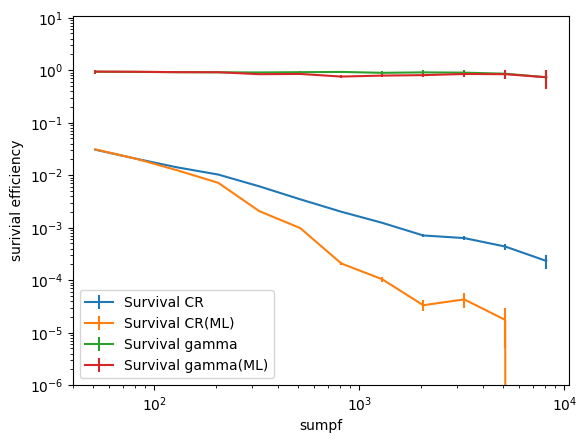

In [142]:
sumpfcenter = (sumpfbins[:-1] + sumpfbins[1:]) / 2

plt.errorbar(sumpfcenter, survivalrate_CR, survivalrate_CR_error, label="Survival CR")
plt.errorbar(
    sumpfcenter,
    survivalrate_CR_ML_new,
    survivalrate_CR_ML_new_error,
    label="Survival CR(ML)",
)
plt.errorbar(
    sumpfcenter, survivalrate_gamma, survivalrate_gamma_error, label="Survival gamma"
)
plt.errorbar(
    sumpfcenter,
    survivalrate_gamma_ML_new,
    survivalrate_gamma_ML_new_error,
    label="Survival gamma(ML)",
)
# plt.plot(sumpfcenter, survivalrate_CR, label="Survival CR")
# plt.plot(sumpfcenter, survivalrate_CR_ML_new, label="Survival CR(ML)")
# plt.plot(sumpfcenter, survivalrate_gamma, label="Survival gamma")
# plt.plot(sumpfcenter, survivalrate_gamma_ML_new, label="Survival gamma(ML)")
# plt.plot(sumpfcenter, missing_gamma, label="missing CR(ML)")
# plt.plot(sumpfcenter, missing_gamma_ML, label="missing CR(ML)")
plt.legend()
plt.xlabel("sumpf")
plt.ylabel("surivial efficiency")
plt.ylim(1e-6,1.1e1)
plt.yscale("log")
plt.xscale("log")
plt.show()


In [13]:
paralist_MC = [
    "nch",
    "theta",
    "phi",
    "sigma",
    "cx",
    "cy",
    "sumpf",
    "summd",
    "mr1",
    "ne",
    "age",
    "inout",
    "prie"
]


In [14]:
gammafile = uproot.open("/home2/chenxu/data/gamma.00339651.root")
gammadata = gammafile["asresult"].arrays(paralist_MC, library="np")


In [15]:
gammadata["S50"] = getS50(gammadata["ne"], gammadata["age"])
MCcut = np.where(
    (gammadata["inout"] == 1)
    & (gammadata["age"] < 1.3)
    & (gammadata["age"] > 0.31)
    & (gammadata["S50"] >= 10**-1.2)
    & (gammadata["nch"] >= 16)
    & (gammadata["theta"] < 60)
)
gammadata = {key: gammadata[key][MCcut] for key in gammadata.keys()}

In [16]:
predictor_isgmma = TabularPredictor.load(
    "/home2/hky/github/Gamma_Energy/AllSky_withCR/agmodel/identitfy_gamma_CR_Allsky"
)

In [17]:
gammadata["isgamma"] = predictor_isgmma.predict_proba(pd.DataFrame(gammadata))[1].to_numpy()


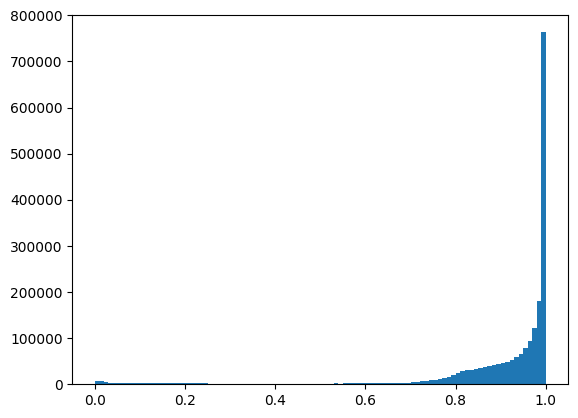

In [18]:
plt.hist(gammadata["isgamma"],bins=100)
plt.show()

In [27]:
np.sum(gammadata["isgamma"]>0.6)/len(gammadata["isgamma"])

0.9415842838255114

In [29]:
1-np.sum(Exptdata["isgamma"]>0.6)/len(Exptdata["isgamma"])

0.9960972603794901

In [20]:
Exptdata = np.load("/home2/hky/github/Gamma_Energy/Exptdata/crabCut_23_05_01/003960/00339651.npz")

In [21]:
Exptdata = {key:Exptdata[key] for key in Exptdata}
Exptdata["isgamma"] = predictor_isgmma.predict_proba(pd.DataFrame(Exptdata))[1].to_numpy()


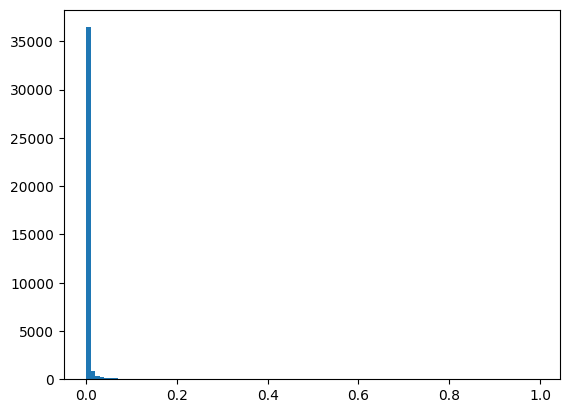

In [22]:
plt.hist(Exptdata["isgamma"],bins=100)
plt.show()

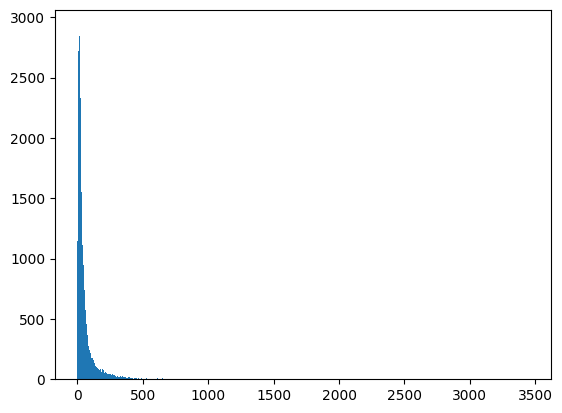

In [16]:
plt.hist(Exptdata["summd"],bins=1000)
plt.show()

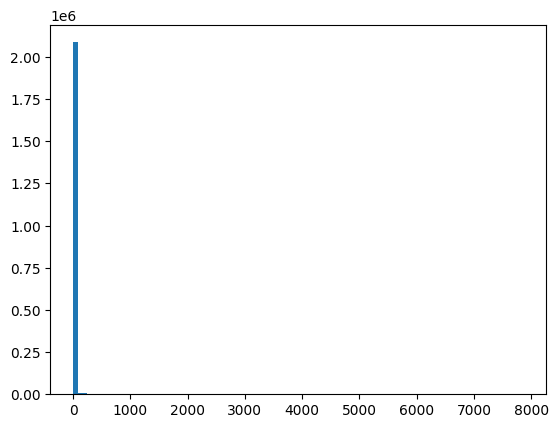

In [21]:
plt.hist(gammadata["summd"],bins=100)
plt.show()

In [2]:
data = np.load("/home2/hky/github/Gamma_Energy/AllSky_withCR/Data/Data_1000.npz")

In [3]:
data ={key:data[key] for key in data}

In [30]:
data["logsummd"] = data["summd"]
data["logsummd"][data["logsummd"] == 0] = 10**-0.8
data["logsummd"] = np.log10(data["logsummd"])
data["logsumpf"] = np.log10(data["sumpf"])

gammadata["logsummd"] = gammadata["summd"]
gammadata["logsummd"][gammadata["logsummd"] == 0] = 10**-0.8
gammadata["logsummd"] = np.log10(gammadata["logsummd"])
gammadata["logsumpf"] = np.log10(gammadata["sumpf"])

In [35]:
xedges = np.linspace(1,5,81)
yedges = np.linspace(-1,4,101)
H_expt, xedges, yedges = np.histogram2d(data["logsumpf"] , data["logsummd"],bins=(xedges, yedges))
H_MC, xedges, yedges = np.histogram2d(gammadata["logsumpf"] , gammadata["logsummd"],bins=(xedges, yedges))
H_expt = H_expt.T
H_MC = H_MC.T

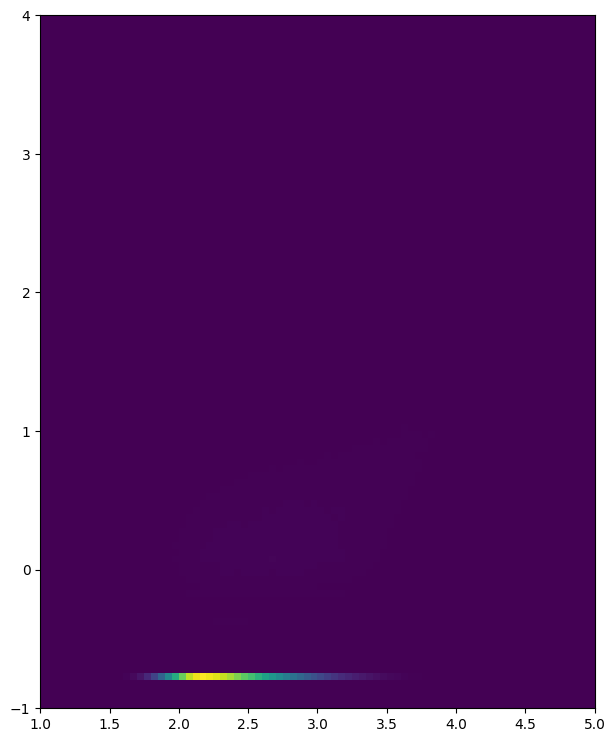

In [37]:

fig = plt.figure(figsize=(16, 9))
plt.imshow(H_MC, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

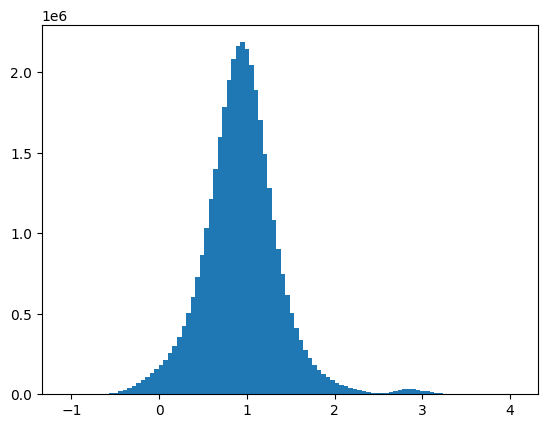

In [19]:
plt.hist(data["logsumpf"]-data["logsummd"],bins=100)
plt.show()

In [42]:
data = np.load("/home2/hky/github/Gamma_Energy/Exptdata/mergedData_nearcrab.npz")

In [43]:
for i in data:
    print(i)

runno
evno
mode
mjd
nch
oldtrig
theta
phi
evenodd
sigma
cx
cy
sumpf
summd
mr1
ne
age
ndf
chi2
Ra
Dec
ha
LST
S50


In [44]:
data={key:data[key] for key in data}

In [45]:
data["logsummd"] = data["summd"]
data["logsummd"][data["logsummd"] == 0] = 10**-0.8
data["logsummd"] = np.log10(data["logsummd"])
data["logsumpf"] = np.log10(data["sumpf"])

In [46]:
xedges = np.linspace(1,5,81)
yedges = np.linspace(-1,4,101)
H_expt, xedges, yedges = np.histogram2d(data["logsumpf"] , data["logsummd"],bins=(xedges, yedges))
H_MC, xedges, yedges = np.histogram2d(gammadata["logsumpf"] , gammadata["logsummd"],bins=(xedges, yedges))
H_expt = H_expt.T
H_MC = H_MC.T

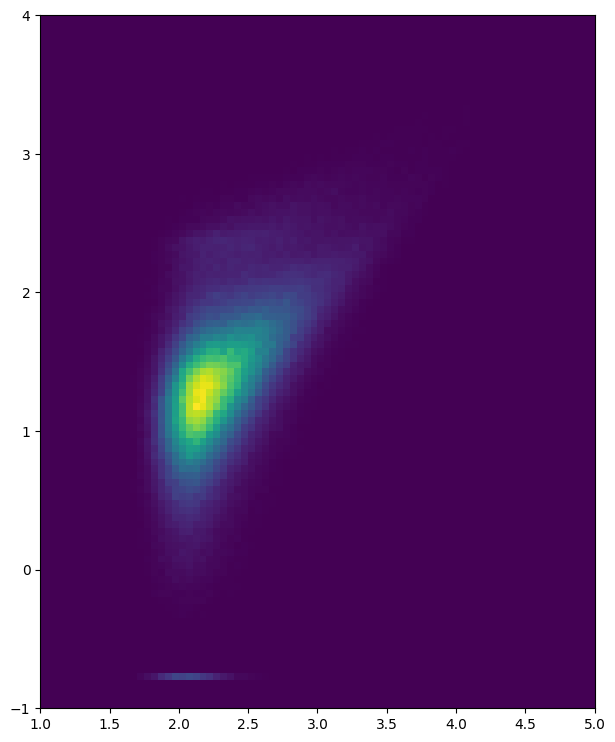

In [47]:

fig = plt.figure(figsize=(16, 9))
plt.imshow(H_expt, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

In [50]:
np.max(data["Dec"]),np.min(data["Dec"])

(22.99999729868587, 21.000007671192478)

In [1]:
import numpy as np
data = np.load("/home2/hky/github/Gamma_Energy/AllSky_withCR/Data/Crab_Dec.npz")
data = {key:data[key] for key in data}

In [2]:
import matplotlib.pyplot as plt

In [3]:
data["logsummd"] = data["summd"]
data["logsummd"][data["logsummd"] == 0] = 10**-0.8
data["logsummd"] = np.log10(data["logsummd"])
data["logsumpf"] = np.log10(data["sumpf"])

In [16]:
xedges = np.linspace(1,5,40)
yedges = np.linspace(-1,4,51)
H_expt, xedges, yedges = np.histogram2d(data["logsumpf"][data["isgamma"]==0] , data["logsummd"][data["isgamma"]==0],bins=(xedges, yedges))
H_MC, xedges, yedges = np.histogram2d(data["logsumpf"][data["isgamma"]==1] , data["logsummd"][data["isgamma"]==1],bins=(xedges, yedges))
H_expt = H_expt.T
H_MC = H_MC.T
H_expt/=np.sum(H_expt)
H_MC/=np.sum(H_MC)

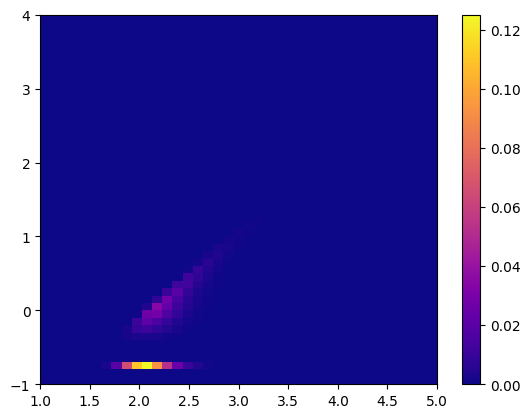

In [17]:

fig,ax = plt.subplots()
c = ax.pcolormesh(xedges, yedges, H_expt, cmap="plasma")
fig.colorbar(c, orientation="vertical")

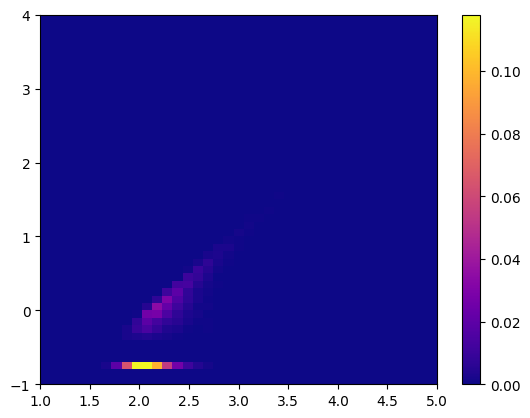

In [23]:

fig,ax = plt.subplots()
c = ax.pcolormesh(xedges, yedges, H_MC, cmap="plasma")
fig.colorbar(c, orientation="vertical")

In [19]:
np.sum(data["isgamma"]==0)

1057954

In [22]:
1/(np.sum(data["isgamma"]==1)/np.sum(data["isgamma"]==0))

158.92353913174102